In [ ]:
from IPython.display import Image
Image(filename='doomlogo.png')

In [2]:
# loading necessary packages

import numpy as np
import gym
import matplotlib.pyplot as plt
import cv2

from gdoom_env import *
from wrappers.gdoom_wrappers import GPreprocessFrame
from wrappers.gdoom_wrappers import GActionsDiscretizer

from gym.utils.play import play

from collections import deque

import tensorflow as tf

## Calling gdoom environment and check that it works 

* 0 - basic
* 1 - deadly_corridor
* 2 - defend_the_center
* 3 - defend_the_line
* 4 - health_gathering
* 5 - my_way_home
* 6 - predict_position
* 7 - take_cover
* 8 - deathmatch

In [3]:
### from gdoom_env

# Make a CPU environemnt the good ol' way (not recommended, see __init__.py).
genv = WGDoomEnv(level=0, frame_size=89)
genv.reset()
a, _, _, _ = genv.step(0)
print( np.asarray(a).shape )

# Also make a GPU environment, but using openai:
env = gym.make("doom_scenario0_96-v0")
frame = env.reset()
print("Frame size for cpu player: ", np.asarray(frame).shape )

/home/wamberg/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Doom> Loading level: /home/wamberg/.local/lib/python3.6/site-packages/vizdoom/scenarios/basic.cfg
(89, 89, 4)
Doom> Loading level: /home/wamberg/.local/lib/python3.6/site-packages/vizdoom/scenarios/basic.cfg
Frame size for cpu player:  (96, 96, 4)


We interact with the simulation through env. To show the simulation running, you can use env.render() to render one frame. Passing in an action as an integer to env.step will generate the next step in the simulation. You can see how many actions are possible from env.action_space and to get a random action you can use env.action_space.sample(). 

In [4]:
# observation, reward, done, info = env.step(action)
env.step(1)
observation, reward, done, info = env.step(1)
print(reward, done)

-4.0 False


In [ ]:
plt.imshow(observation,interpolation='none')

In [5]:
env.reset()
rewards = []
for _ in range(100):
    #env.render()
    state, reward, done, info = env.step(env.action_space.sample()) # take a random action
    rewards.append(reward)
    if done:
        rewards = []
        env.reset()
        
print(rewards[-10:])

[-4.0, -4.0, -9.1, -4.0, -4.0, -4.0, -4.0, -4.0, -9.1, -4.0]


Setting up a function to crop images

In [6]:
def crop(state):
    state = np.asarray(state)
    crop = state[30:-10,10:-20] # crop screen ie remove roof
    norm_img = crop/255.0 # normalize
    
    return cv2.resize(norm_img, img_size) # return resized image
    #return norm_img

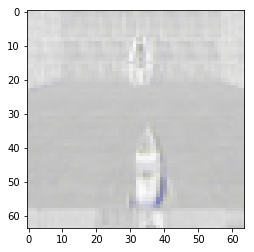

In [7]:
img_size = (64, 64)

plt.imshow(crop(observation),interpolation='none')

new_frame = crop(observation)
state_size_tuple = np.asarray(new_frame).shape
state_size = list(state_size_tuple)

In [ ]:
test = crop(observation)
test.shape
type(test)

## Q Learning

$\underline{Algorithm:}$ a function that calculates the quality of a state-action combination: $Q:S\times A\to {\mathbb  {R}}$

Before learning begins, $Q$ is initialized to a possibly arbitrary fixed value (chosen by the programmer). Then, at each time $t$ the agent selects an action $a_{t}$, observes a reward $r_{t}$, enters a new state $s_{t+1}$ (that may depend on both the previous state $s_{t}$ and the selected action), and $Q$ is updated. The core of the algorithm is a simple value iteration update, using the weighted average of the old value and the new information:

$Q^{new}(s_{t},a_{t})\leftarrow (1-\alpha )\cdot \underbrace {Q(s_{t},a_{t})} _{\text{old value}}+\underbrace {\alpha } _{\text{learning rate}}\cdot \overbrace {{\bigg (}\underbrace {r_{t}} _{\text{reward}}+\underbrace {\gamma } _{\text{discount factor}}\cdot \underbrace {\max _{a}Q(s_{t+1},a)} _{\text{estimate of optimal future value}}{\bigg )}} ^{\text{learned value}}$

where $r_{t}$ is the reward received when moving from the state $s_{t}$ to the state $s_{t+1}$, and $\alpha$ is the learning rate ( $0<\alpha \leq 1$).

Start by defining our hyperparameters

In [8]:
total_episodes = 1000          # number of episodes to learn from
max_steps = 100                # max steps in an episode
gamma = 0.99                   # discounting factor

eps_start = 1.0                # probability for exploration at start
eps_stop = 0.01                # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration probability

action_size = 3                # number of possible actions

alpha = 0.0002                 # learning rate
memory_size = 1000000          # memory capacity
batch_size = 64                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

Creating the Deep Q Neural Network

Convolutional Neural Network based on Thomas Simonini

In [9]:
class DQNN:
    def __init__(self, state_size, action_size, alpha, name='DQNN'): 
        # the state inupts
        self.state_size = state_size
        self.action_size = action_size
        self.alpha = alpha
        
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, *state_size], name="inputs_")
            
            #self.actions_ = tf.placeholder(tf.float32, [None, action_size], name="actions_")
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            self.target_Q = tf.placeholder(tf.float32, [None], name="target")
            
            self.conv1 = tf.layers.conv2d(inputs = self.inputs_,
                                         filters = 32,
                                         kernel_size = [8,8],
                                         strides = [4,4],
                                         padding = "VALID",
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                         name = "conv1")
            
            self.conv1_batchnorm = tf.layers.batch_normalization(self.conv1,
                                        training = True,
                                        epsilon = 1e-5,
                                        name = 'batch_norm1')
            
            self.conv1_out = tf.nn.elu(self.conv1_batchnorm, name="conv1_out")
            
            self.conv2 = tf.layers.conv2d(inputs = self.conv1_out,
                                 filters = 64,
                                 kernel_size = [4,4],
                                 strides = [2,2],
                                 padding = "VALID",
                                 kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 name = "conv2")
        
            self.conv2_batchnorm = tf.layers.batch_normalization(self.conv2,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                     name = 'batch_norm2')

            self.conv2_out = tf.nn.elu(self.conv2_batchnorm, name="conv2_out")
            
            self.conv3 = tf.layers.conv2d(inputs = self.conv2_out,
                                 filters = 128,
                                 kernel_size = [4,4],
                                 strides = [2,2],
                                 padding = "VALID",
                                 kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 name = "conv3")
        
            self.conv3_batchnorm = tf.layers.batch_normalization(self.conv3,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                     name = 'batch_norm3')

            self.conv3_out = tf.nn.elu(self.conv3_batchnorm, name="conv3_out")            
            
            self.flatten = tf.layers.flatten(self.conv3_out)            
            
            self.fc = tf.layers.dense(inputs = self.flatten,
                                  units = 512,
                                  activation = tf.nn.elu,
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                  name="fc1")
            
            
            self.output = tf.layers.dense(inputs = self.fc, 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                        units = 3, 
                                        activation=None)
            
            ### Train with loss (targetQ - Q)^2
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            self.loss = tf.reduce_mean(tf.square(self.target_Q - self.Q))
            
            self.opt = tf.train.RMSPropOptimizer(self.alpha).minimize(self.loss)

Creating replay buffer / experience replay

In [10]:
class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen = max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size),
                                size = batch_size,
                                replace = False)
        
        return [self.buffer[i] for i in index]

Training

In [11]:
# Reset the graph
tf.reset_default_graph()

# Instantiate the DQNetwork
DQNetwork = DQNN(state_size, action_size, alpha)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.


Populate the experience memory

In [12]:
# Initialize the simulation
env.reset()

# Take one random step
state, reward, done, _ = env.step(env.action_space.sample())
state = crop(state)

memory = Memory(max_size=memory_size)

# Take a bunch of random actions and store the experiences
for i in range(pretrain_length):
    # env.render() # Uncomment the line below to watch the simulation
    
    # Make the random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    next_state = crop(next_state)
    
    if done:
        # We have finished the episode
        next_state = np.zeros(state_size_tuple)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state, done))
        
        # Start new episode
        env.reset()        
        # and take one random step
        state, reward, done, _ = env.step(env.action_space.sample())
        state = crop(state)
    
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state, done))
        state = next_state
        state = crop(state)
        

In [13]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []

with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    
    for episode in range(1, total_episodes):
        total_reward = 0
        t = 0
        
        while t < max_steps:
            step += 1
            
            # env.render() # uncomment to watch training
            
            # greedy or exploration move
            explore_p = eps_stop + (eps_start - eps_stop)*np.exp(-decay_rate*step)
            
            if explore_p > np.random.rand():
                # Exploration move -> random action
                action = env.action_space.sample() 
                #print(action)

            else: 
                # Greedy move -> Take action from Q-network
                feed = {DQNetwork.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(DQNetwork.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            next_state = crop(next_state)
            total_reward += reward
            
            if done:
                # episode ends, no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(episode),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((episode, total_reward))
            
                # Add experience to memory
                memory.add((state, action, reward, next_state,done))
                
                # Start new episode
                env.reset()
                # Take one random step
                state, reward, done, _ = env.step(env.action_space.sample())
                state = crop(state)
                
            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state, done))
                state = next_state
                state = crop(state)
                t += 1 
                
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch], ndmin = 3)
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch], ndmin = 3)

            dones = np.array([each[4] for each in batch])      
            
            target_Q_batch = []
            
            # Train the network, get Q values for next state
            Q_next_state = sess.run(DQNetwork.output, feed_dict={DQNetwork.inputs_: next_states})
            
            # Set target_Q = r if episode ends at s+1, otherwise = r+gamma*maxQ(s',a')
            for i in range(len(batch)):
                terminal = dones[i]
                
                if terminal:
                    target_Q_batch.append(rewards[i])
                    
                else:
                    target = rewards[i] + gamma * np.max(Q_next_state[i])
                    target_Q_batch.append(target)
                    
            target_batch = np.array([each for each in target_Q_batch])

            loss, _ = sess.run([DQNetwork.loss, DQNetwork.opt],
                                    feed_dict={DQNetwork.inputs_: states,
                                               DQNetwork.target_Q: target_batch,
                                               DQNetwork.actions_: actions})
                 
       
        # Save model every 5 episodes
        if episode % 5 == 0:
            save_path = saver.save(sess, "./models/model.ckpt")
            print("Model Saved")

Episode: 1 Total reward: 29.599999999999994 Training loss: 175.2332 Explore P: 0.9985
Episode: 2 Total reward: -297.3 Training loss: 159.9016 Explore P: 0.9927
Episode: 3 Total reward: -307.40000000000003 Training loss: 144.0580 Explore P: 0.9869
Episode: 4 Total reward: -82.89999999999998 Training loss: 12.1244 Explore P: 0.9832
Episode: 5 Total reward: -292.0 Training loss: 10.4962 Explore P: 0.9775
Model Saved
Episode: 6 Total reward: -73.69999999999996 Training loss: 370.0931 Explore P: 0.9739
Episode: 7 Total reward: -11.400000000000006 Training loss: 33.4013 Explore P: 0.9717
Episode: 8 Total reward: 30.69999999999999 Training loss: 170.4602 Explore P: 0.9704
Episode: 9 Total reward: 58.8 Training loss: 49.7976 Explore P: 0.9696
Episode: 10 Total reward: -119.89999999999998 Training loss: 175.1546 Explore P: 0.9654
Model Saved
Episode: 11 Total reward: -302.5 Training loss: 220.3141 Explore P: 0.9598
Episode: 12 Total reward: -297.20000000000005 Training loss: 48.7515 Explore P: 

Episode: 100 Total reward: -302.3 Training loss: 945.9857 Explore P: 0.6934
Model Saved
Episode: 101 Total reward: -297.2 Training loss: 1021.8319 Explore P: 0.6894
Episode: 102 Total reward: 34.7 Training loss: 800.6415 Explore P: 0.6884
Episode: 103 Total reward: 34.7 Training loss: 950.6688 Explore P: 0.6874
Episode: 104 Total reward: 96.9 Training loss: 1643.4363 Explore P: 0.6872
Episode: 105 Total reward: -292.1 Training loss: 1647.9404 Explore P: 0.6832
Model Saved
Episode: 106 Total reward: 34.8 Training loss: 1120.9169 Explore P: 0.6823
Episode: 107 Total reward: 75.9 Training loss: 2079.4180 Explore P: 0.6820
Episode: 108 Total reward: -292.1 Training loss: 1415.4351 Explore P: 0.6780
Episode: 109 Total reward: 67.80000000000001 Training loss: 1584.8352 Explore P: 0.6775
Episode: 110 Total reward: -1.0 Training loss: 1840.7256 Explore P: 0.6774
Model Saved
Episode: 111 Total reward: -302.3 Training loss: 961.3110 Explore P: 0.6735
Episode: 112 Total reward: 72.9 Training loss

Episode: 200 Total reward: -323.0 Training loss: 2235.6509 Explore P: 0.5058
Model Saved
Episode: 201 Total reward: -73.4 Training loss: 2269.9395 Explore P: 0.5051
Episode: 202 Total reward: 88.9 Training loss: 2469.1304 Explore P: 0.5049
Episode: 203 Total reward: -317.8 Training loss: 2654.0552 Explore P: 0.5020
Episode: 204 Total reward: -302.3 Training loss: 3383.2910 Explore P: 0.4991
Episode: 205 Total reward: -146.29999999999995 Training loss: 2627.0786 Explore P: 0.4968
Model Saved
Episode: 206 Total reward: -312.70000000000005 Training loss: 2787.9780 Explore P: 0.4939
Episode: 207 Total reward: -1.0 Training loss: 4212.2803 Explore P: 0.4939
Episode: 208 Total reward: 76.9 Training loss: 2496.5564 Explore P: 0.4935
Episode: 209 Total reward: -302.5 Training loss: 4090.8772 Explore P: 0.4907
Episode: 210 Total reward: -312.7 Training loss: 2813.0115 Explore P: 0.4879
Model Saved
Episode: 211 Total reward: -302.5 Training loss: 2367.9507 Explore P: 0.4850
Episode: 212 Total re

Episode: 298 Total reward: -317.8 Training loss: 3714.8706 Explore P: 0.3614
Episode: 299 Total reward: -312.8 Training loss: 5068.7715 Explore P: 0.3593
Episode: 300 Total reward: 17.5 Training loss: 3270.8491 Explore P: 0.3587
Model Saved
Episode: 301 Total reward: -31.69999999999999 Training loss: 3180.8145 Explore P: 0.3578
Episode: 302 Total reward: -79.99999999999997 Training loss: 4997.3721 Explore P: 0.3566
Episode: 303 Total reward: 84.9 Training loss: 3928.8091 Explore P: 0.3564
Episode: 304 Total reward: -317.9 Training loss: 3398.2480 Explore P: 0.3544
Episode: 305 Total reward: 68.9 Training loss: 2859.0674 Explore P: 0.3541
Model Saved
Episode: 306 Total reward: -117.29999999999995 Training loss: 2192.6929 Explore P: 0.3527
Episode: 307 Total reward: -317.8 Training loss: 3004.5642 Explore P: 0.3507
Episode: 308 Total reward: -307.6 Training loss: 5663.6055 Explore P: 0.3487
Episode: 309 Total reward: -179.99999999999997 Training loss: 3858.9956 Explore P: 0.3476
Episode:

Episode: 398 Total reward: -271.70000000000005 Training loss: 2925.2668 Explore P: 0.2582
Episode: 399 Total reward: -287.1 Training loss: 2522.9551 Explore P: 0.2568
Episode: 400 Total reward: 55.8 Training loss: 2366.5000 Explore P: 0.2566
Model Saved
Episode: 401 Total reward: 84.9 Training loss: 4388.4561 Explore P: 0.2564
Episode: 402 Total reward: -86.89999999999998 Training loss: 2568.8848 Explore P: 0.2555
Episode: 403 Total reward: 96.9 Training loss: 1856.8711 Explore P: 0.2554
Episode: 404 Total reward: -312.5 Training loss: 2227.7402 Explore P: 0.2540
Episode: 405 Total reward: -111.1 Training loss: 6042.2920 Explore P: 0.2527
Model Saved
Episode: 406 Total reward: 59.8 Training loss: 7095.2773 Explore P: 0.2525
Episode: 407 Total reward: -28.69999999999999 Training loss: 3813.0210 Explore P: 0.2519
Episode: 408 Total reward: -1.0 Training loss: 2101.0679 Explore P: 0.2518
Episode: 409 Total reward: -287.0 Training loss: 5069.6592 Explore P: 0.2504
Episode: 410 Total reward

Episode: 498 Total reward: -317.90000000000003 Training loss: 5206.8545 Explore P: 0.1911
Episode: 499 Total reward: -323.00000000000006 Training loss: 7671.0020 Explore P: 0.1901
Episode: 500 Total reward: 67.9 Training loss: 5348.3589 Explore P: 0.1900
Model Saved
Episode: 501 Total reward: -185.7 Training loss: 4477.0400 Explore P: 0.1890
Episode: 502 Total reward: -318.0 Training loss: 5459.4829 Explore P: 0.1879
Episode: 503 Total reward: -317.90000000000003 Training loss: 6862.7275 Explore P: 0.1869
Episode: 504 Total reward: -323.0 Training loss: 5543.7002 Explore P: 0.1858
Episode: 505 Total reward: 96.9 Training loss: 6285.8853 Explore P: 0.1858
Model Saved
Episode: 506 Total reward: 84.9 Training loss: 3919.2671 Explore P: 0.1857
Episode: 507 Total reward: -317.8 Training loss: 6756.6055 Explore P: 0.1847
Episode: 508 Total reward: -312.5 Training loss: 6604.4287 Explore P: 0.1837
Episode: 509 Total reward: -307.4 Training loss: 6185.4844 Explore P: 0.1826
Episode: 510 Total 

Episode: 599 Total reward: 96.9 Training loss: 11756.0312 Explore P: 0.1424
Episode: 600 Total reward: -63.99999999999997 Training loss: 13954.8057 Explore P: 0.1420
Model Saved
Episode: 601 Total reward: -8.599999999999994 Training loss: 17796.2285 Explore P: 0.1417
Episode: 602 Total reward: 48.8 Training loss: 16992.8906 Explore P: 0.1416
Episode: 603 Total reward: 75.80000000000001 Training loss: 14208.6260 Explore P: 0.1415
Episode: 604 Total reward: -317.90000000000003 Training loss: 14176.9736 Explore P: 0.1408
Episode: 605 Total reward: -16.69999999999999 Training loss: 18290.1406 Explore P: 0.1405
Model Saved
Episode: 606 Total reward: 63.8 Training loss: 13869.1973 Explore P: 0.1404
Episode: 607 Total reward: 96.9 Training loss: 18000.9551 Explore P: 0.1403
Episode: 608 Total reward: -323.1 Training loss: 14461.5469 Explore P: 0.1396
Episode: 609 Total reward: 89.0 Training loss: 18810.6191 Explore P: 0.1395
Episode: 610 Total reward: -318.0 Training loss: 17387.0293 Explore 

Episode: 697 Total reward: 96.9 Training loss: 18346.5898 Explore P: 0.1027
Episode: 698 Total reward: -297.3 Training loss: 17980.1562 Explore P: 0.1021
Episode: 699 Total reward: 75.9 Training loss: 18805.1250 Explore P: 0.1021
Episode: 700 Total reward: 42.7 Training loss: 20980.0176 Explore P: 0.1020
Model Saved
Episode: 701 Total reward: 75.9 Training loss: 20774.7949 Explore P: 0.1019
Episode: 702 Total reward: 79.9 Training loss: 20557.1680 Explore P: 0.1019
Episode: 703 Total reward: -307.6 Training loss: 22243.6289 Explore P: 0.1013
Episode: 704 Total reward: -1.0 Training loss: 17489.2246 Explore P: 0.1013
Episode: 705 Total reward: 75.9 Training loss: 12097.9355 Explore P: 0.1013
Model Saved
Episode: 706 Total reward: -302.6 Training loss: 23268.1152 Explore P: 0.1007
Episode: 707 Total reward: -3.5999999999999943 Training loss: 16485.8457 Explore P: 0.1006
Episode: 708 Total reward: -85.4 Training loss: 30341.5664 Explore P: 0.1004
Episode: 709 Total reward: -3.599999999999

Episode: 797 Total reward: -292.1 Training loss: 21490.5156 Explore P: 0.0786
Episode: 798 Total reward: -287.1 Training loss: 10938.0059 Explore P: 0.0782
Episode: 799 Total reward: 96.9 Training loss: 27874.7676 Explore P: 0.0782
Episode: 800 Total reward: -292.29999999999995 Training loss: 26658.7168 Explore P: 0.0778
Model Saved
Episode: 801 Total reward: -297.4 Training loss: 16336.1992 Explore P: 0.0774
Episode: 802 Total reward: 80.9 Training loss: 18837.9902 Explore P: 0.0773
Episode: 803 Total reward: -302.4 Training loss: 20887.1641 Explore P: 0.0769
Episode: 804 Total reward: -297.4 Training loss: 14701.7598 Explore P: 0.0765
Episode: 805 Total reward: -302.5 Training loss: 36007.6719 Explore P: 0.0762
Model Saved
Episode: 806 Total reward: 46.7 Training loss: 20021.0078 Explore P: 0.0761
Episode: 807 Total reward: -1.0 Training loss: 21241.3223 Explore P: 0.0761
Episode: 808 Total reward: -302.40000000000003 Training loss: 16718.6523 Explore P: 0.0757
Episode: 809 Total rew

Episode: 896 Total reward: -302.4 Training loss: 21831.0508 Explore P: 0.0580
Episode: 897 Total reward: -251.29999999999998 Training loss: 23910.3086 Explore P: 0.0577
Episode: 898 Total reward: -1.0 Training loss: 29482.1875 Explore P: 0.0577
Episode: 899 Total reward: -307.6 Training loss: 16697.4199 Explore P: 0.0574
Episode: 900 Total reward: -1.0 Training loss: 14606.0234 Explore P: 0.0574
Model Saved
Episode: 901 Total reward: -292.3 Training loss: 21262.8359 Explore P: 0.0571
Episode: 902 Total reward: -292.1 Training loss: 18740.9844 Explore P: 0.0569
Episode: 903 Total reward: -292.19999999999993 Training loss: 20791.8535 Explore P: 0.0566
Episode: 904 Total reward: -297.4 Training loss: 24822.5586 Explore P: 0.0563
Episode: 905 Total reward: -302.5 Training loss: 13127.3027 Explore P: 0.0560
Model Saved
Episode: 906 Total reward: -302.3 Training loss: 23922.0371 Explore P: 0.0558
Episode: 907 Total reward: 47.800000000000004 Training loss: 29186.4199 Explore P: 0.0557
Episod

Episode: 994 Total reward: -302.5 Training loss: 10234.1191 Explore P: 0.0410
Episode: 995 Total reward: -297.4 Training loss: 15818.2383 Explore P: 0.0408
Model Saved
Episode: 996 Total reward: 64.9 Training loss: 12094.3682 Explore P: 0.0408
Episode: 997 Total reward: -297.40000000000003 Training loss: 10056.9209 Explore P: 0.0406
Episode: 998 Total reward: -282.09999999999997 Training loss: 20291.8496 Explore P: 0.0405
Episode: 999 Total reward: -297.3 Training loss: 18031.7598 Explore P: 0.0403


In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0, 0.5, 'Total Reward')

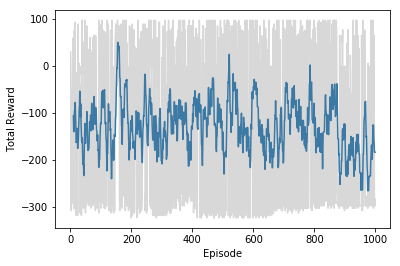

In [15]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Setting up TensorBoard

In [ ]:
rewards_list

## Create batches

## Train agent